# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
from tqdm.notebook import tqdm
pd.options.plotting.backend = "plotly"
from scipy.signal import find_peaks
import pingouin as pg
from tqdm import tqdm
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


# Data imports

In [4]:
data = pd.read_hdf('/Users/Oliver/Google Drive/AG Remy/Petra/MSDBtoVTAfiber/01_Data/fph_processed.h5', 'fph')
data = data.loc[data.Mouse!=95]  # exclude mouse 95
data['RecSweep'] = data['Recording'] + data['Sweep'].astype(str)
data

sweep_index       FPH   Licking      FPH2  Velocity    Position  \
0                 0  0.314202  0.016882  5.167423 -0.287890    0.692175   
1                 1  0.314175  0.016882  4.793903 -0.020048    0.689463   
2                 2  0.312792  0.016882  4.423856 -0.010443    0.690750   
3                 3  0.312468  0.016882  4.056797 -0.003584    0.691525   
4                 4  0.311742  0.016882  3.691351  0.002602    0.692075   
...             ...       ...       ...       ...       ...         ...   
396601          595  0.250374  0.101976 -0.682024  1.584445  282.769813   
396602          596  0.250378  0.030224 -0.633697  2.970393  283.835325   
396603          597  0.249876  0.052199 -0.587437  5.165518  284.757762   
396604          598  0.249964  0.107931 -0.542907  6.353448  285.100925   
396605          599  0.250245  0.122390 -0.499834  5.898836  285.176212   

            FPH3  Mouse  Sweep       Date  LEDgain  \
0       5.122468    102      1 2018-12-12      0.2   
1       4.735889    102      1 2018-12-12      0.2   
2       4.346891    102      1 2018-12-12      0.2   
3       3.957003    102      1 2018-12-12      0.2   
4       3.568352    102      1 2018-12-12      0.2   
...          ...    ...    ...        ...      ...   
396601 -0.471686    100     13 2019-02-05      0.2   
396602 -0.378084    100     13 2019-02-05      0.2   
396603 -0.285490    100     13 2019-02-05      0.2   
396604 -0.194151    100     13 2019-02-05      0.2   
396605 -0.104132    100     13 2019-02-05      0.2   

                           Recording                       RecSweep  
0       12.12.2018_102_reward Folder  12.12.2018_102_reward Folder1  
1       12.12.2018_102_reward Folder  12.12.2018_102_reward Folder1  
2       12.12.2018_102_reward Folder  12.12.2018_102_reward Folder1  
3       12.12.2018_102_reward Folder  12.12.2018_102_reward Folder1  
4       12.12.2018_102_reward Folder  12.12.2018_102_reward Folder1  
...                              ...                            ...  
396601         2019.02.05_100 Folder        2019.02.05_100 Folder13  
396602         2019.02.05_100 Folder        2019.02.05_100 Folder13  
396603         2019.02.05_100 Folder        2019.02.05_100 Folder13  
396604         2019.02.05_100 Folder        2019.02.05_100 Folder13  
396605         2019.02.05_100 Folder        2019.02.05_100 Folder13  

[328856 rows x 13 columns]

In [5]:
data.Recording.unique()

array(['12.12.2018_102_reward Folder', '13.12.2018_102_reward Folder',
       '13.12.2018_102_reward_video Folder',
       '13.12.2018_96_reward_video Folder',
       '13.12.2018_100_reward_video Folder',
       '17.12.2018_96_reward_video Folder',
       '17.12.2018_100_reward_video Folder',
       '17.12.2018_102_reward_trials Folder',
       '18.12.2018_96_reward_video Folder',
       '18.12.2018_100_reward_video Folder',
       '18.12.2018_102_reward_video Folder',
       '19.12.2018_96_reward_video Folder',
       '19.12.2018_100_reward_video Folder',
       '19.12.2018_102_reward_video Folder', '2019.01.11_102 Folder',
       '2019.01.21_97_powertest Folder', '2019.01.21_99_powertest Folder',
       '2019.01.22_97 Folder', '2019.01.22_99 Folder',
       '2019.01.23_102 Folder', '2019.02.01_96 Folder',
       '2019.02.01_99 Folder', '2019.02.04_ 102 Folder',
       '2019.02.04_96 Folder', '2019.02.04_97 Folder',
       '2019.02.04_99 Folder', '2019.02.04_100 Folder',
       '2019.

# Data wrangling

In [6]:
# add rest/locomotion/lick timing information

for exp in tqdm(data.RecSweep.unique()):
    data_exp = data.loc[data.RecSweep==exp]#.reset_index(drop=True)
    data_exp['Time_sec'] = np.arange(stop=len(data_exp))/10

    # resting periods
    rest_idx_raw = data_exp.index[data_exp.Velocity<2]
    rest_epochs = (pd.Series(rest_idx_raw).diff()!=1).astype(int).cumsum()
    data_exp.loc[rest_idx_raw, 'rest_epochs'] = rest_epochs.values
    rest_epoch_counts = rest_epochs.value_counts()
    long_rest_epochs = rest_epoch_counts.index[rest_epoch_counts > 30].to_list()
    data_exp['long_rest'] = 0
    data_exp.loc[data_exp.rest_epochs.isin(long_rest_epochs), 'long_rest'] = 1
    
    # locomotion periods
    data_exp['VeloSmooth'] = data_exp.Velocity.rolling(10, center=True).mean()
    data_exp['locomotion_epochs'] = np.nan
    loco_idx_raw = data_exp.index[data_exp.VeloSmooth>2]
    loco_epochs = (pd.Series(loco_idx_raw).diff()!=1).astype(int).cumsum()
    data_exp.loc[loco_idx_raw, 'locomotion_epochs'] = loco_epochs.values
    loco_epoch_counts = loco_epochs.value_counts()
    long_loco_epochs = loco_epoch_counts.index[loco_epoch_counts > 20].to_list()
    loco_epochs_after_rest = list((data_exp['locomotion_epochs'].shift(-20)*data_exp['long_rest']).unique()[:].astype(int))
    data_exp['long_locomotion'] = 0
    data_exp.loc[data_exp.locomotion_epochs.isin(list(set(long_loco_epochs) & set(loco_epochs_after_rest))), 'long_locomotion'] = 1
 
    # licking
    data_exp.Licking = data_exp.Licking / data_exp.Licking.max()
    data_exp['Licks'] = 0
    data_exp.loc[data_exp.index[find_peaks(data_exp.Licking, height=0.5, distance=int(3))[0]], 'Licks'] = 1
    data_exp['LickBouts'] = (data_exp.Licks.rolling(10).mean()>0).astype(int)

    # indeces
    idx = {}
    idx['onset_longloco'] = data_exp.index[data_exp.long_locomotion.astype(int).diff()==1].to_list()
    idx['onset_lickbout'] = data_exp.index[data_exp.LickBouts.astype(int).diff()==1].to_list()
    idx['onset_lickbout_initial'] = [i for i in idx['onset_lickbout'] if (data_exp.loc[i-40:i-1, 'Licks'].sum()==0)&(i>40)]# lickbouton_initial (first lick after >2sec not licking)

    # on/offset times into dataframe
    def onset_timing(behaviour_exp, onset_name, ffill_limit):
        behaviour_exp['onset_time'] = np.nan
        behaviour_exp.loc[(behaviour_exp[onset_name]==1), 'onset_time'] = behaviour_exp.loc[(behaviour_exp[onset_name]==1), 'Time_sec']
        behaviour_exp.onset_time = behaviour_exp.onset_time.fillna(method='ffill', limit=ffill_limit).fillna(method='bfill', limit=int(ffill_limit))
        behaviour_exp['onset_time'] = behaviour_exp.Time_sec - behaviour_exp.onset_time
        return behaviour_exp['onset_time']
    
    for key in idx.keys():
        data_exp[key] = 0
        data_exp.loc[idx[key], key] = 1
        ffill_limit = int(5/data_exp.Time_sec.diff().mean())
        if 'onset_lickbout' in key:
            ffill_limit = int(2/data_exp.Time_sec.diff().mean())
        data_exp[key+'_time'] = onset_timing(data_exp, key, ffill_limit)
        data_exp[key+'_epoch'] = data_exp[key].cumsum().shift(int(ffill_limit)).fillna(0)

    for epoch in data_exp.onset_longloco_epoch.unique():
        if ((data_exp.onset_longloco_epoch==epoch)&(data_exp.onset_longloco_time==0)).sum()>0:
            data_exp.loc[data_exp.onset_longloco_epoch==epoch, 'FPH2_zeroed'] = data_exp.loc[data_exp.onset_longloco_epoch==epoch, 'FPH2'] - data_exp.loc[(data_exp.onset_longloco_epoch==epoch)&(data_exp.onset_longloco_time==0), 'FPH2'].values
            data_exp.loc[data_exp.onset_longloco_epoch==epoch, 'FPH3_zeroed'] = data_exp.loc[data_exp.onset_longloco_epoch==epoch, 'FPH3'] - data_exp.loc[(data_exp.onset_longloco_epoch==epoch)&(data_exp.onset_longloco_time==0), 'FPH3'].values
    
    data.loc[data.RecSweep==exp, ['onset_longloco', 'onset_longloco_time', 'onset_longloco_epoch', 'FPH2_zeroed', 'FPH3_zeroed', 'long_rest', 'long_locomotion', 'onset_lickbout_initial_time', 'VeloSmooth']] = data_exp[['onset_longloco', 'onset_longloco_time', 'onset_longloco_epoch', 'FPH2_zeroed', 'FPH3_zeroed', 'long_rest', 'long_locomotion', 'onset_lickbout_initial_time', 'VeloSmooth']]
data['onset_longloco_time'] = round(data['onset_longloco_time']*10)/10
data['onset_lickbout_initial_time'] = round(data['onset_lickbout_initial_time']*10)/10

  0%|          | 0/455 [00:00<?, ?it/s]/var/folders/2s/lgxvrsmn351gfx01lgs9wft80000gn/T/ipykernel_15146/886422276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_exp['Time_sec'] = np.arange(stop=len(data_exp))/10
/var/folders/2s/lgxvrsmn351gfx01lgs9wft80000gn/T/ipykernel_15146/886422276.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_exp.loc[rest_idx_raw, 'rest_epochs'] = rest_epochs.values
/var/folders/2s/lgxvrsmn351gfx01lgs9wft80000gn/T/ipykernel_15146/886422276.py:13: SettingWithCopyWa

# Rest vs Run (Fig 1D)

<AxesSubplot:xlabel='loco_state', ylabel='FPH2'>

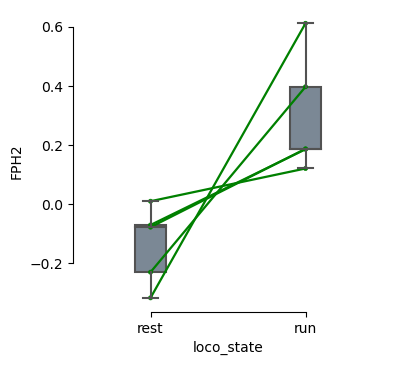

In [7]:
data[['long_rest', 'long_locomotion']]
data.loc[data.long_rest==1, 'loco_state'] = 'rest'
data.loc[data.long_locomotion==1, 'loco_state'] = 'run'
pg.plot_paired(data=data.loc[data.LEDgain>0.1].groupby(['Mouse', 'loco_state']).mean(
    ).reset_index(), dv='FPH2', within='loco_state', subject='Mouse')
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/MSDBtoVTAfiber/fph_restvsrun.pdf')

In [8]:
pg.pairwise_tests(data=data.loc[data.LEDgain>0.1].groupby(['Mouse', 'loco_state']).mean(
    ).reset_index(), dv='FPH2', within='loco_state', subject='Mouse')

Contrast     A    B  Paired  Parametric         T  dof alternative  \
0  loco_state  rest  run    True        True -2.928056  4.0   two-sided   

      p-unc   BF10    hedges  
0  0.042897  2.475 -2.305382

# Velocity correlation (Fig 1C)

<AxesSubplot:xlabel='VelocityBin', ylabel='FPH2'>

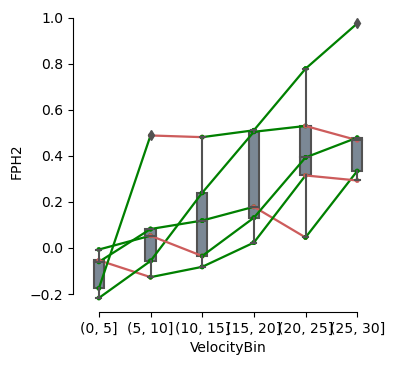

In [9]:
data['VelocityBin'], velobins = pd.cut(data.Velocity, bins=[0,5,10,15,20,25,30], retbins=True)
pg.plot_paired(data=data.loc[(data.LEDgain>0.1)].groupby(['Mouse', 'VelocityBin']).mean(
    ).reset_index(), dv='FPH2', within='VelocityBin', subject='Mouse')
# plt.savefig('/Users/Oliver/Google Drive/AG Remy/Petra/MSDBtoVTAfiber/fph_velocorrelation.pdf')

In [10]:
pg.rm_anova(data=data.loc[(data.LEDgain>0.1)].groupby(['Mouse', 'VelocityBin']).mean(
    ).reset_index(), dv='FPH2', within='VelocityBin', subject='Mouse')

Source  ddof1  ddof2         F     p-unc       ng2       eps
0  VelocityBin      5     20  9.650232  0.000083  0.499201  0.483069

In [11]:
pg.pairwise_tests(data=data.loc[(data.LEDgain>0.1)].groupby(['Mouse', 'VelocityBin']).mean(
    ).reset_index(), dv='FPH2', within='VelocityBin', subject='Mouse')

Contrast         A         B  Paired  Parametric         T  dof  \
0   VelocityBin    (0, 5]   (5, 10]    True        True -1.523601  4.0   
1   VelocityBin    (0, 5]  (10, 15]    True        True -1.823195  4.0   
2   VelocityBin    (0, 5]  (15, 20]    True        True -2.700366  4.0   
3   VelocityBin    (0, 5]  (20, 25]    True        True -3.440107  4.0   
4   VelocityBin    (0, 5]  (25, 30]    True        True -4.183466  4.0   
5   VelocityBin   (5, 10]  (10, 15]    True        True -0.876248  4.0   
6   VelocityBin   (5, 10]  (15, 20]    True        True -1.871842  4.0   
7   VelocityBin   (5, 10]  (20, 25]    True        True -3.133289  4.0   
8   VelocityBin   (5, 10]  (25, 30]    True        True -9.027627  4.0   
9   VelocityBin  (10, 15]  (15, 20]    True        True -2.993549  4.0   
10  VelocityBin  (10, 15]  (20, 25]    True        True -2.993456  4.0   
11  VelocityBin  (10, 15]  (25, 30]    True        True -5.776669  4.0   
12  VelocityBin  (15, 20]  (20, 25]    True        True -1.693488  4.0   
13  VelocityBin  (15, 20]  (25, 30]    True        True -2.807297  4.0   
14  VelocityBin  (20, 25]  (25, 30]    True        True -1.487144  4.0   

   alternative     p-unc    BF10    hedges  
0    two-sided  0.202281   0.844 -0.955404  
1    two-sided  0.142348   1.068 -1.293971  
2    two-sided  0.054074   2.099 -1.970371  
3    two-sided  0.026291   3.513 -2.311905  
4    two-sided  0.013879   5.563 -2.729574  
5    two-sided  0.430365   0.533 -0.218521  
6    two-sided  0.134544    1.11 -0.707436  
7    two-sided  0.035074   2.857 -1.147614  
8    two-sided  0.000834  43.002 -1.486030  
9    two-sided  0.040197   2.592 -0.500636  
10   two-sided  0.040201   2.592 -0.968610  
11   two-sided  0.004460  12.651 -1.315106  
12   two-sided  0.165614   0.964 -0.518467  
13   two-sided  0.048450   2.269 -0.868893  
14   two-sided  0.211184   0.821 -0.324612